In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Comparison with SaTScan

Having discovered further trouble replicating the results of SaTScan, we introduce some more support for reading and writing SaTScan files, and test various corner cases.

The class `AbstractSTScan` works with "generic time" (so just numbers, now interpretted as some time unit _before_ an epoch time).  This allows us to concentrate on the details.  We also introduce a more complicated rule about cases when the boundary of a disc contains more than one point (see below).

The class `STScanNumpy` takes the same data and settings as `AbstractSTScan`, but uses a parallel `numpy` programme style to improve performance.  Like the original implementation, and unlike `AbstractSTScan`, it does nothing special about events which fall on the boundary of disks.

In the following, we set the "population" limits to 50% (the SaTScan default) and set the maximum radius and time lengths to be effectively infinity, given the inputs.  Hence these results should be directly comparable with the results from SaTScan for a "Prospective Analyses" / "Space-Time" and "Space-Time Permutation" with otherwise default options.

## Setup

- Import what we need
- Various functions to build test data and get into the various classes which implement the different algorithms.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import open_cp.stscan, open_cp.stscan2
import numpy as np

In [3]:
def make_random_data(s=100):
    times = np.floor(np.random.random(size=s) * 200)
    times.sort()
    times = np.flipud(times)
    coords = np.random.random(size=(2,s)) * 100
    return coords, times

def build_ab_scan(coords, times):
    ab_scan = open_cp.stscan2.AbstractSTScan(coords, times)
    ab_scan.geographic_radius_limit = 1000
    ab_scan.geographic_population_limit = 0.5
    ab_scan.time_max_interval = 200
    ab_scan.time_population_limit = 0.5
    return ab_scan

def build_stscan_numpy(coords, times):
    stsn = open_cp.stscan2.STScanNumpy(coords, times)
    stsn.geographic_radius_limit = 1000
    stsn.geographic_population_limit = 0.5
    stsn.time_max_interval = 200
    stsn.time_population_limit = 0.5
    return stsn

def to_timed_points(coords, times):
    """Convert to days before 2017-04-01 and use `STSTrainerSlow`."""
    timestamps = (np.timedelta64(1,"D") / np.timedelta64(1,"s")) * times * np.timedelta64(1,"s")
    timestamps = np.datetime64("2017-04-01T00:00") - timestamps
    return open_cp.data.TimedPoints(timestamps, coords)

def build_trainer(coords, times):
    trainer = open_cp.stscan.STSTrainerSlow()
    trainer.data = to_timed_points(coords, times)
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

def build_trainer_fast(coords, times):
    trainer = open_cp.stscan.STSTrainer()
    trainer.data = to_timed_points(coords, times)
    trainer.time_max_interval = np.timedelta64(200,"D")
    trainer.time_population_limit = 0.5
    trainer.geographic_population_limit = 0.5
    trainer.geographic_radius_limit = 1000
    return trainer

# Comparison

We find that _most_ of the time, we obtain the same clusters.  But sometimes we don't.  This is down to:

- Non-deterministic ordering.  If we compare things in different orders, we can break ties in different ways.
- As the discs are always centred on events, it is possible for different discs to contain the same events.  As we generate further clusters by finding the next most significant cluster which is _disjoint_ for current clusters, if we again process things in a different order, then we can obtain different disks.

From this point of view, obtaining perfect agreement with SaTScan seems an almost hopeless ideal!

In [4]:
coords, times = make_random_data()
ab_scan = build_ab_scan(coords, times)
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 11.92115972  43.09277343] 6.89195262409 1.0 4.53631770935
[ 31.94937435   4.11588879] 6.56043152592 17.0 2.65052201767
[ 89.76972581  47.94338879] 18.6923013299 50.0 2.41322208499
[ 57.21397614  96.85464114] 15.2103626296 52.0 1.93458180016
[ 68.29370349  77.07218443] 3.97922940838 46.0 1.48054158004
[ 10.02630886   9.44112969] 8.90414766417 40.0 1.31617631778
[ 67.95258199   2.09667156] 14.0049372144 36.0 1.25419699044
[ 44.35257964  59.61860954] 6.37304547626 66.0 1.01785137944
[ 30.59721872  76.91932255] 3.91447024333 70.0 0.886403810197
[ 77.52654118  94.30266431] 3.1323194023 71.0 0.846430089743
[ 64.61408159  23.76970396] 1.35152956261 77.0 0.702947397527
[  9.81481701  98.700353  ] 10.9690747002 92.0 0.391361957646
[ 49.63081641  36.76676608] 14.9570131065 81.0 0.186850811499
[ 91.28441729  79.20475082] 11.0724638377 78.0 0.0471012146402
[ 32.87341791  92.29859862] 9.32725097461 86.0 0.0109248357106


In [5]:
stsn = build_stscan_numpy(coords, times)
all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 11.92115972  43.09277343] 6.89195262409 1.0 4.53631770935
[ 31.94937435   4.11588879] 6.56043152592 17.0 2.65052201767
[ 89.76972581  47.94338879] 18.6923013299 50.0 2.41322208499
[ 57.21397614  96.85464114] 15.2103626296 52.0 1.93458180016
[ 70.64342397  80.28358293] 3.97922940838 46.0 1.48054158004
[ 10.10856222   4.67131531] 12.6416330545 40.0 1.31617631778
[ 67.95258199   2.09667156] 14.0049372144 36.0 1.25419699044
[ 45.47912456  53.3459223 ] 6.37304547626 66.0 1.01785137944
[ 30.59721872  76.91932255] 3.91447024333 70.0 0.886403810197
[ 77.52654118  94.30266431] 3.1323194023 71.0 0.846430089743
[ 64.61408159  23.76970396] 1.35152956261 77.0 0.702947397527
[  9.81481701  98.700353  ] 10.9690747002 92.0 0.391361957646
[ 42.03632246  24.12849294] 14.7445680312 82.0 0.169569507969
[ 91.28441729  79.20475082] 11.0724638377 78.0 0.0471012146402
[ 32.87341791  92.29859862] 9.32725097461 86.0 0.0109248357106


In [6]:
trainer = build_trainer(coords, times)
result = trainer.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result.clusters, result.time_ranges, result.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 11.92115972,  43.09277343]), radius=6.8920215436187897) 1.0 4.53631770935
Cluster(centre=array([ 25.66594021,   2.22969759]), radius=6.5604971302342046) 17.0 2.65052201767
Cluster(centre=array([ 89.76972581,  47.94338879]), radius=18.692488252891842) 50.0 2.41322208499
Cluster(centre=array([ 57.21397614,  96.85464114]), radius=15.210514733232648) 52.0 1.93458180016
Cluster(centre=array([ 70.64342397,  80.28358293]), radius=3.9792692006741905) 46.0 1.48054158004
Cluster(centre=array([ 10.02630886,   9.44112969]), radius=8.9042367056426315) 40.0 1.31617631778
Cluster(centre=array([ 67.95258199,   2.09667156]), radius=14.005077263782544) 36.0 1.25419699044
Cluster(centre=array([ 44.35257964,  59.61860954]), radius=6.3731092067103123) 66.0 1.01785137944
Cluster(centre=array([ 30.59721872,  76.91932255]), radius=3.9145093880280117) 70.0 0.886403810197
Cluster(centre=array([ 77.52654118,  94.30266431]), radius=3.1323507254964227) 71.0 0.846430089743
Cluster(centre=arra

In [7]:
trainer_fast = build_trainer_fast(coords, times)
result_fast = trainer_fast.predict(time=np.datetime64("2017-04-01T00:00"))
for c, t, s in zip(result_fast.clusters, result_fast.time_ranges, result_fast.statistics):
    assert np.datetime64("2017-04-01T00:00") == t[1]
    t = (np.datetime64("2017-04-01T00:00") - t[0]) / np.timedelta64(1,"D")
    print(c, t, s)

Cluster(centre=array([ 11.92115972,  43.09277343]), radius=6.8919526240925482) 1.0 4.53631770935
Cluster(centre=array([ 31.94937435,   4.11588879]), radius=6.5604315259189452) 17.0 2.65052201767
Cluster(centre=array([ 89.76972581,  47.94338879]), radius=18.692301329878543) 50.0 2.41322208499
Cluster(centre=array([ 57.21397614,  96.85464114]), radius=15.210362629606351) 52.0 1.93458180016
Cluster(centre=array([ 70.64342397,  80.28358293]), radius=3.9792294083801063) 46.0 1.48054158004
Cluster(centre=array([ 10.10856222,   4.67131531]), radius=12.641633054457746) 40.0 1.31617631778
Cluster(centre=array([ 67.95258199,   2.09667156]), radius=14.004937214410399) 36.0 1.25419699044
Cluster(centre=array([ 45.47912456,  53.3459223 ]), radius=6.3730454762555491) 66.0 1.01785137944
Cluster(centre=array([ 30.59721872,  76.91932255]), radius=3.914470243325578) 70.0 0.886403810197
Cluster(centre=array([ 77.52654118,  94.30266431]), radius=3.1323194023023992) 71.0 0.846430089743
Cluster(centre=array

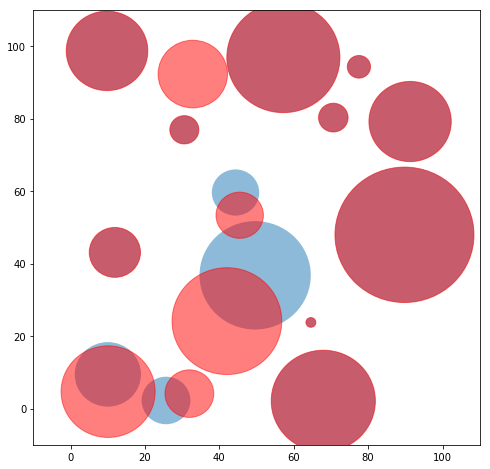

In [8]:
# Plots the old "trainer" implementation against the abstract numpy implementation

import matplotlib.patches

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlim=[-10,110], ylim=[-10,110])
for c in result.clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5)
    ax.add_patch(cir)
for c in all_clusters:
    cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5, color="red")
    ax.add_patch(cir)

## Timings

The newer code in `AbstractSTScan` is a bit quicker.  The Numpy code is definitely quicker.

In [22]:
%timeit( list(ab_scan.find_all_clusters()) )

1 loop, best of 3: 2.7 s per loop


In [23]:
%timeit( list(stsn.find_all_clusters()) )

1 loop, best of 3: 177 ms per loop


In [24]:
%timeit( trainer.predict() )

1 loop, best of 3: 3.57 s per loop


In [25]:
%timeit( trainer_fast.predict() )

1 loop, best of 3: 181 ms per loop


## Optionally save

We can write the data out in SaTScan format for comparison purposes.  Be sure to adjust Advanced Analysis options in SaTScan to reflect the settings we used above (no limit of size of clusters, but a population limit of 50% for both space and time).~

In [ ]:
#ab_scan.to_satscan("satscan_test2", 1000)

# Grided data

Where we have found quite different behaviour from SaTScan is in "boundary" behaviour.  Consider the case when a disk's boundary (it's circumference) contains more than one event.  The `STSTrainer` class always considers all events inside or on the edge of the disk.  But SaTScan will _sometimes_ consider events inside the disc, and then only _some_ of the events on the boundary.

Notice in particular that we can expect this to happen a lot if the input data is on a regular grid.

We try to replicate this behaviour in `AbstractSTScan` by considering all possibilities of events on the boundary being counted or not.  Unfortunately, we then seem to beat SaTScan at its own game, and consider too many subsets, resulting in finding clusters which SaTScan does not.

The first example below shows where `AbstractSTScan` is more aggresive than SaTScan.  The 2nd example shows where SaTScan does indeed fail to consider all events in a disc, and gets the same result as `AbstractSTScan`.

## Generate example random data

We use the grid abilities of `STSTrainer`.

In [26]:
def trainer_to_data(trainer):
    coords = trainer.data.coords
    times = (np.datetime64("2017-04-01T00:00") - trainer.data.timestamps) / np.timedelta64(1,"s")
    times /= (np.timedelta64(1,"D") / np.timedelta64(1,"s"))
    times = np.floor(times)
    
    return coords, times

np.testing.assert_array_almost_equal(trainer_to_data(trainer)[0], coords)
np.testing.assert_array_almost_equal(trainer_to_data(trainer)[1], times)

In [27]:
trainer = build_trainer(*make_random_data())
region = open_cp.RectangularRegion(xmin=0, ymin=0, xmax=100, ymax=100)
ab_scan = build_ab_scan( *trainer_to_data( trainer.grid_coords(region, grid_size=20) ) )

In [28]:
all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  70.] 20.0 10.0 3.35205338619
[ 50.  10.] 20.0 7.0 2.22714527424
[ 90.  90.] 40.0 86.0 2.04912794103
[ 10.  10.] 0.0 11.0 1.31450916714
[ 10.  30.] 0.0 51.0 0.231871917017
[ 10.  90.] 0.0 66.0 0.0608145106305


In [ ]:
#ab_scan.to_satscan("satscan_test1", 1000)

## Reload some data

Here's one we prepared earlier.  It shows a case where our aggressive algorithm finds a cluster which SaTScan does not.

In [29]:
def find_satscan_ids_for_mask(in_disc, time):
    in_disc &= ab_scan.timestamps <= time
    in_disc = set( (x,y) for x,y in ab_scan.coords[:,in_disc].T )
    return [i for i in satscan_data.geo if satscan_data.geo[i] in in_disc]

def find_mask(centre, radius):
    return np.sum((ab_scan.coords - np.array(centre)[:,None])**2, axis=0) <= radius**2

def to_our_indexes(sat_scan_indexes):
    out = set()
    for i in sat_scan_indexes:
        x, y = satscan_data.geo[i]
        m = (ab_scan.coords[0] == x) & (ab_scan.coords[1] == y)
        for j in np.arange(ab_scan.coords.shape[1])[m]:
            out.add(j)
    return out

In [30]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test3", 1000)
ab_scan = build_ab_scan( *satscan_data.to_coords_time() )

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 50.  30.] 20.0 45 1.78403489846
[ 30.  70.] 20.0 13 1.2377140172
[ 90.  70.] 0.0 20 0.719563298144
[ 10.  30.] 0.0 70 0.532363441331
[ 70.  10.] 0.0 55 0.253033910799
[ 10.  90.] 0.0 42 0.124080354492
[ 70.  70.] 0.0 97 0.0766353331714
[ 90.  90.] 0.0 97 0.0766353331714
[ 10.  50.] 0.0 46 0.0173811215268
[ 90.  30.] 0.0 91 0.0109248357106


In [31]:
# Cluster which SaTScan finds -- In this case, seemingly SaTScan includes all events
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc, 70)

[6, 11, 21, 22]

In [32]:
# Our cluster-- all events in or on the disc
in_disc = find_mask([50,30], 20)
find_satscan_ids_for_mask(in_disc, 45)

[2, 7, 9, 11, 21]

In [33]:
# The subset of events our algorithm chooses to use
in_disc = all_clusters[0].mask
find_satscan_ids_for_mask(in_disc, 45)

[2, 9, 11, 21]

In [34]:
# The numpy code should, mostly, replicate what SaTScan does
stsn = build_stscan_numpy( *satscan_data.to_coords_time() )

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  30.] 20.0 70.0 1.62216107924
[ 30.  70.] 0.0 13.0 0.928218893946
[ 90.  70.] 0.0 20.0 0.719563298144
[ 90.  10.] 40.0 1.0 0.670748515888
[ 50.  50.] 0.0 92.0 0.528417664973
[ 10.  70.] 0.0 33.0 0.444466091444
[ 10.  90.] 0.0 42.0 0.124080354492
[ 90.  90.] 0.0 97.0 0.0766353331714
[ 70.  70.] 0.0 97.0 0.0766353331714
[ 50.  70.] 0.0 68.0 0.0700453772522
[ 10.  50.] 0.0 46.0 0.0173811215268


## 2nd Example

This example actually seems to show SaTScan not including all points in a disc.  SaTScan reports:

    1.Location IDs included.: 23, 6, 16
      Coordinates / radius..: (30,30) / 20.00
      Time frame............: 993 to 1000
      Number of cases.......: 3
      Expected cases........: 0.42
      Observed / expected...: 7.14
      Test statistic........: 3.352053
      P-value...............: 0.202
      Recurrence interval...: 5.0 units

Now, we note that:
- Event 23 occurs at times 967 and 924, which are both _outside_ the time window.
- The disc centred at (30,30) of radius 20 contains events 6, 11, 16, 23 and 24.
- If we manually compute the statistic for this disk and time, we get the same value as SaTScan (to be precise, if we change the space window to only include events 6, 16 and 23, we obtain the sample "expected" count).
- The Numpy accelerated code fails to find this cluster, as it includes all events in the disk.

In [35]:
satscan_data = open_cp.stscan2.SaTScanData("satscan_test1", 1000)
coords, times = satscan_data.to_coords_time()
ab_scan = build_ab_scan(coords, times)

all_clusters = list(ab_scan.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 30.  30.] 20.0 7 3.35205338619
[ 50.  50.] 0.0 38 2.71560614559
[ 90.  70.] 0.0 29 1.09086496593
[ 70.  90.] 0.0 27 0.639868972963
[ 10.  90.] 0.0 60 0.43341798412
[ 90.  90.] 0.0 84 0.367754306996
[ 90.  10.] 0.0 42 0.316663808549
[ 10.  10.] 0.0 98 0.221514808107
[ 70.  10.] 0.0 93 0.166852706468
[ 30.  70.] 0.0 63 0.133405703443
[ 30.  90.] 0.0 97 0.0871975764851
[ 10.  50.] 0.0 34 0.0871975764851
[ 50.  70.] 0.0 64 0.0173811215268
[ 50.  10.] 0.0 87 0.00689368813393


In [36]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,7)

[6, 16]

In [37]:
in_disc = find_mask([30,30], 20)
find_satscan_ids_for_mask(in_disc,10000)

[6, 11, 16, 23, 24]

In [38]:
satscan_data.geo[6], satscan_data.geo[16], satscan_data.geo[11], satscan_data.geo[23], satscan_data.geo[24]

((10.0, 30.0), (30.0, 10.0), (50.0, 30.0), (30.0, 30.0), (30.0, 50.0))

In [39]:
time_mask = times <= 7
space_mask = np.sum( (coords - np.array([30,30])[:,None])**2, axis=0) <= 20**2

expected = np.sum(space_mask) * np.sum(time_mask) / 100
actual = np.sum(space_mask & time_mask)
actual, expected, ab_scan._statistic(actual, expected, 100)

(3, 0.56999999999999995, 2.5821322730708438)

In [40]:
# The above Statistic is smaller than the one SaTScan finds, because the expected count is too large
# But if we limit the spacial region to the ids SaTScan claims, we obtain a perfect match
expected = len(to_our_indexes([23, 6, 16])) * np.sum(time_mask) / 100
expected

0.41999999999999998

In [41]:
# The numpy accelerated code doesn't find the same clusters
stsn = build_stscan_numpy(coords, times)

all_clusters = list(stsn.find_all_clusters())
for c in all_clusters:
    print(c.centre, c.radius, c.time, c.statistic)

[ 10.  10.] 20.0 7.0 3.00992229396
[ 50.  50.] 0.0 38.0 2.71560614559
[ 90.  70.] 0.0 29.0 1.09086496593
[ 50.  30.] 0.0 52.0 0.96536944933
[ 70.  90.] 0.0 27.0 0.639868972963
[ 30.  30.] 0.0 76.0 0.581812742761
[ 10.  90.] 0.0 60.0 0.43341798412
[ 90.  90.] 0.0 84.0 0.367754306996
[ 90.  10.] 0.0 42.0 0.316663808549
[ 70.  10.] 0.0 93.0 0.166852706468
[ 30.  70.] 0.0 63.0 0.133405703443
[ 10.  50.] 0.0 34.0 0.0871975764851
[ 30.  90.] 0.0 97.0 0.0871975764851
[ 50.  70.] 0.0 64.0 0.0173811215268
[ 50.  10.] 0.0 87.0 0.00689368813393
